# Init

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/0-학자연

Mounted at /content/drive/
/content/drive/MyDrive/0-학자연


In [4]:
from __future__ import annotations

import os
import csv
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple

import numpy as np
from PIL import Image, ImageDraw

# ---- Optional plotting (SHAP uses matplotlib internally) ----
import matplotlib.pyplot as plt

# ---- Torch + SHAP ----
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import shap

IMG_SIZE = 128
NUM_SAMPLES = 2000

# Generate samples

In [11]:
# ============================================================
# 1) Geometry: Convex hull (monotone chain) + rotating calipers
# rotating calipers 알고리즘은 볼록다각형에서 정의되므로 여기서도 볼록하게 만들었음
# ============================================================

def _cross(o: np.ndarray, a: np.ndarray, b: np.ndarray) -> float:
    # OA x OB -> 회전 방향 측정
    return float((a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0]))


def convex_hull(points: np.ndarray) -> np.ndarray:
    # 주어진 점들을 모두 포함하는 가장 작은 볼록다각형을 반환함
    pts = np.asarray(points, dtype=np.float64)
    if len(pts) < 3:
        return pts

    # Sort by x, then y
    pts = pts[np.lexsort((pts[:, 1], pts[:, 0]))]

    lower: List[np.ndarray] = []
    for p in pts:
        while len(lower) >= 2 and _cross(lower[-2], lower[-1], p) <= 1e-12:
            lower.pop()
        lower.append(p)

    upper: List[np.ndarray] = []
    for p in pts[::-1]:
        while len(upper) >= 2 and _cross(upper[-2], upper[-1], p) <= 1e-12:
            upper.pop()
        upper.append(p)

    hull = np.vstack((lower[:-1], upper[:-1]))
    return hull


def _dist2(a: np.ndarray, b: np.ndarray) -> float:
    d = a - b
    return float(d[0] * d[0] + d[1] * d[1])


def rotating_calipers_diameter(hull: np.ndarray) -> float:
    # O(N)에 rotating calipers 문제를 풀어서 반환함

    P = np.asarray(hull, dtype=np.float64)
    n = len(P)
    if n < 2:
        return 0.0
    if n == 2:
        return math.sqrt(_dist2(P[0], P[1]))

    # 삼각형의 크기를 구함 -> 이를 바탕으로 "antipodal advance"를 진행함
    def area2(i: int, j: int, k: int) -> float:
        return abs(_cross(P[i], P[j], P[k]))

    j = 1
    max_d2 = 0.0

    for i in range(n):
        ni = (i + 1) % n

        # ni와 가장 멀리 떨어진 edge를 구함
        while True:
            nj = (j + 1) % n
            if area2(i, ni, nj) > area2(i, ni, j) + 1e-12:
                j = nj
            else:
                break

        # Update max distance with current antipodal point
        max_d2 = max(max_d2, _dist2(P[i], P[j]), _dist2(P[ni], P[j]))

    return math.sqrt(max_d2)


# ============================================================
# 2) Dataset generation: convex polygons + fast rasterization
# ============================================================

@dataclass
class PolyGenConfig:
    img_size: int = 128
    num_samples: int = 2000
    poly_range: Tuple[int, int] = (4, 10)     # hull vertex count target range [lo, hi]
    out_dir: Path = Path("./dataset")
    antialias: int = 4                        # supersampling factor for clean edges
    center_margin: float = 0.2                # keep polygon center within [-1+margin, 1-margin]
    center_std: float = 0.35                  # center sampling std
    point_pool_range: Tuple[int, int] = (20, 60)  # raw points sampled before hull
    min_edge_len: float = 0.03                # reject degenerate tiny hull edges
    max_tries: int = 5000                     # safeguard to avoid infinite loops


def sample_center(center_margin: float, center_std: float) -> Tuple[float, float]:
    while True:
        cx, cy = np.random.normal(scale=center_std, size=2)
        if abs(cx) <= 1 - center_margin and abs(cy) <= 1 - center_margin:
            return float(cx), float(cy)


def normalize_hull_to_box(hull: np.ndarray, cx: float, cy: float, margin: float) -> np.ndarray:
    """
    Translate hull to (cx,cy), then scale to fit within [-1+margin, 1-margin] in both axes.
    """
    H = np.asarray(hull, dtype=np.float64)

    # Shift hull to have mean at origin, then shift to (cx,cy)
    H0 = H - H.mean(axis=0, keepdims=True)
    H1 = H0 + np.array([cx, cy], dtype=np.float64)

    # Scale so bounding box fits within [-1+margin, 1-margin]
    min_xy = H1.min(axis=0)
    max_xy = H1.max(axis=0)

    # available half-range in each axis from center to boundary
    half_range = 1.0 - margin
    span = max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])
    if span < 1e-9:
        return H1

    # scale factor to fit inside [-half_range, +half_range] around 0, then shift already included
    # compute current hull bounds relative to center
    # safer: ensure all coords satisfy abs(coord) <= half_range by scaling around (cx,cy)
    rel = H1 - np.array([cx, cy], dtype=np.float64)
    max_abs = np.max(np.abs(rel))
    if max_abs < 1e-9:
        return H1

    s = (half_range) / max_abs
    H2 = np.array([cx, cy], dtype=np.float64) + s * rel
    return H2


def hull_is_reasonable(hull: np.ndarray, min_edge_len: float) -> bool:
    if len(hull) < 3:
        return False
    H = np.asarray(hull, dtype=np.float64)
    n = len(H)
    # Reject very small edges / near-degenerate polygons
    for i in range(n):
        d = np.linalg.norm(H[(i + 1) % n] - H[i])
        if d < min_edge_len:
            return False
    # Area check (shoelace)
    x, y = H[:, 0], H[:, 1]
    area2 = abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    return area2 > 1e-4


def generate_random_convex_polygon(cfg: PolyGenConfig) -> np.ndarray:
    lo, hi = cfg.poly_range
    for _ in range(cfg.max_tries):
        cx, cy = sample_center(cfg.center_margin, cfg.center_std)
        pool_n = np.random.randint(cfg.point_pool_range[0], cfg.point_pool_range[1] + 1)

        # Sample points around (cx,cy) with bounded radius, then hull
        angles = np.random.uniform(0, 2 * np.pi, size=pool_n)
        # radius distribution: bias towards boundary but keep variety
        r = np.random.beta(2.0, 2.0, size=pool_n)  # in (0,1)
        # max radius to stay within box
        max_r = min(1 - cfg.center_margin - abs(cx), 1 - cfg.center_margin - abs(cy))
        max_r = max(max_r, 0.05)
        rr = (0.2 + 0.8 * r) * max_r

        pts = np.stack([cx + rr * np.cos(angles), cy + rr * np.sin(angles)], axis=1)

        hull = convex_hull(pts)

        if lo <= len(hull) <= hi:
            hull = normalize_hull_to_box(hull, cx, cy, cfg.center_margin)
            if hull_is_reasonable(hull, cfg.min_edge_len):
                return hull

    raise RuntimeError("Failed to generate a suitable convex polygon. Increase max_tries or relax constraints.")


def coords_to_pixel(points_xy: np.ndarray, n: int) -> List[Tuple[float, float]]:
    P = np.asarray(points_xy, dtype=np.float64)
    x = (P[:, 0] + 1.0) * 0.5 * (n - 1)
    y = (1.0 - (P[:, 1] + 1.0) * 0.5) * (n - 1)  # invert y
    return list(map(tuple, np.stack([x, y], axis=1)))


def polygon_to_image(poly_xy: np.ndarray, img_size: int, antialias: int = 4) -> np.ndarray:
    """
    antialias: 고해상도 -> 저해상도로 깔끔하게 이어지도록 할 때 사용
    """
    aa = max(1, int(antialias))
    big = img_size * aa

    img = Image.new("L", (big, big), color=0)
    draw = ImageDraw.Draw(img)

    pts = coords_to_pixel(poly_xy, big)
    draw.polygon(pts, fill=255)

    if aa > 1:
        img = img.resize((img_size, img_size), resample=Image.Resampling.LANCZOS)

    return np.array(img, dtype=np.uint8)


def generate_dataset(cfg: PolyGenConfig) -> None:
    out_dir = cfg.out_dir
    img_dir = out_dir / "images"
    img_dir.mkdir(parents=True, exist_ok=True)

    labels_path = out_dir / "labels.csv"
    rows = []

    for idx in range(1, cfg.num_samples + 1):
        poly = generate_random_convex_polygon(cfg)
        diameter = rotating_calipers_diameter(poly)

        img_arr = polygon_to_image(poly, cfg.img_size, cfg.antialias)
        filename = f"{idx:06d}.png"
        Image.fromarray(img_arr).save(img_dir / filename)

        # Save label; you can also save num_vertices for analysis
        rows.append((filename, float(diameter), int(len(poly))))

        if idx % 200 == 0 or idx == cfg.num_samples:
            print(f"[generate] {idx}/{cfg.num_samples} done")

    with open(labels_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filename", "diameter", "num_vertices"])
        w.writerows(rows)

    print(f"[generate] saved images to: {img_dir}")
    print(f"[generate] saved labels to: {labels_path}")

cfg = PolyGenConfig(
    img_size=IMG_SIZE,
    num_samples=NUM_SAMPLES,
    poly_range=(3,20),
    out_dir=Path.cwd() / "dataset",
    antialias=0,
)
generate_dataset(cfg)

[generate] 200/2000 done
[generate] 400/2000 done
[generate] 600/2000 done
[generate] 800/2000 done
[generate] 1000/2000 done
[generate] 1200/2000 done
[generate] 1400/2000 done
[generate] 1600/2000 done
[generate] 1800/2000 done
[generate] 2000/2000 done
[generate] saved images to: /content/drive/MyDrive/0-학자연/dataset/images
[generate] saved labels to: /content/drive/MyDrive/0-학자연/dataset/labels.csv


# CNN

In [5]:
class PolygonDiameterDataset(Dataset):
    def __init__(self, root: Path, split: str, img_size: int, val_ratio: float = 0.15, seed: int = 42):
        self.root = Path(root)
        self.img_dir = self.root / "images"
        self.labels_path = self.root / "labels.csv"
        self.img_size = img_size

        # Load labels
        items = []
        with open(self.labels_path, "r", newline="") as f:
            r = csv.DictReader(f)
            for row in r:
                items.append((row["filename"], float(row["diameter"])))

        # Deterministic split
        rng = np.random.default_rng(seed)
        idx = np.arange(len(items))
        rng.shuffle(idx)
        split_at = int(len(items) * (1.0 - val_ratio))

        if split == "train":
            sel = idx[:split_at]
        elif split == "val":
            sel = idx[split_at:]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.items = [items[i] for i in sel]

        # For regression stability, normalize label roughly.
        # Max possible distance in [-1,1]^2 is 2*sqrt(2) ~ 2.828.
        self.label_scale = 2.0 * math.sqrt(2.0)

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, i: int):
        fname, diam = self.items[i]
        img = Image.open(self.img_dir / fname).convert("L")

        # Ensure size
        if img.size != (self.img_size, self.img_size):
            img = img.resize((self.img_size, self.img_size), resample=Image.Resampling.BILINEAR)

        x = np.array(img, dtype=np.float32) / 255.0  # [0,1]
        x = x[None, :, :]  # (1,H,W)

        y = np.float32(diam / self.label_scale)  # normalized target
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32)


class SimpleCNNRegressor(nn.Module):
    """
    Simple CNN (no ResNet) for scalar regression.
    """
    def __init__(self, in_ch: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # Adaptive pooling avoids hard-coding the spatial size
        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 1)

        self.drop = nn.Dropout(p=0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # /2

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # /4

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # /8

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


def train_model(
    dataset_root: Path,
    img_size: int,
    epochs: int = 15,
    batch_size: int = 64,
    lr: float = 1e-3,
    seed: int = 42,
    device: str | None = None,
) -> Path:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[train] device={device}")

    train_ds = PolygonDiameterDataset(dataset_root, "train", img_size=img_size, seed=seed)
    val_ds = PolygonDiameterDataset(dataset_root, "val", img_size=img_size, seed=seed)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = SimpleCNNRegressor(in_ch=1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    out_path = dataset_root / "simple_cnn_best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_losses.append(loss.item())

        tr = float(np.mean(train_losses))
        va = float(np.mean(val_losses))
        print(f"[train] epoch {ep:02d} | train_mse={tr:.6f} | val_mse={va:.6f}")

        if va < best_val:
            best_val = va
            torch.save({"model_state": model.state_dict(), "img_size": img_size}, out_path)
            print(f"[train]  saved best -> {out_path} (val_mse={best_val:.6f})")

    return out_path


ckpt_path = train_model(
    dataset_root=Path.cwd() / "dataset",
    img_size=IMG_SIZE,
    epochs=15,
    batch_size=64,
    lr=1e-3,
)
print(f"[train] best checkpoint: {ckpt_path}")




[train] device=cuda


KeyboardInterrupt: 

# SHAP

[explain] runtime_device=cuda
[explain] shap_device=cpu (use_cpu_for_shap=True)
[explain] model output shape check: (2, 1)
[explain] normalized targets (true vs pred):
  00: true=0.5142, pred=0.5048
  01: true=0.5694, pred=0.5619
  02: true=0.5374, pred=0.5231
  03: true=0.5028, pred=0.5053
  04: true=0.5969, pred=0.5586
  05: true=0.5664, pred=0.5084
  06: true=0.5309, pred=0.5151
  07: true=0.4785, pred=0.4823


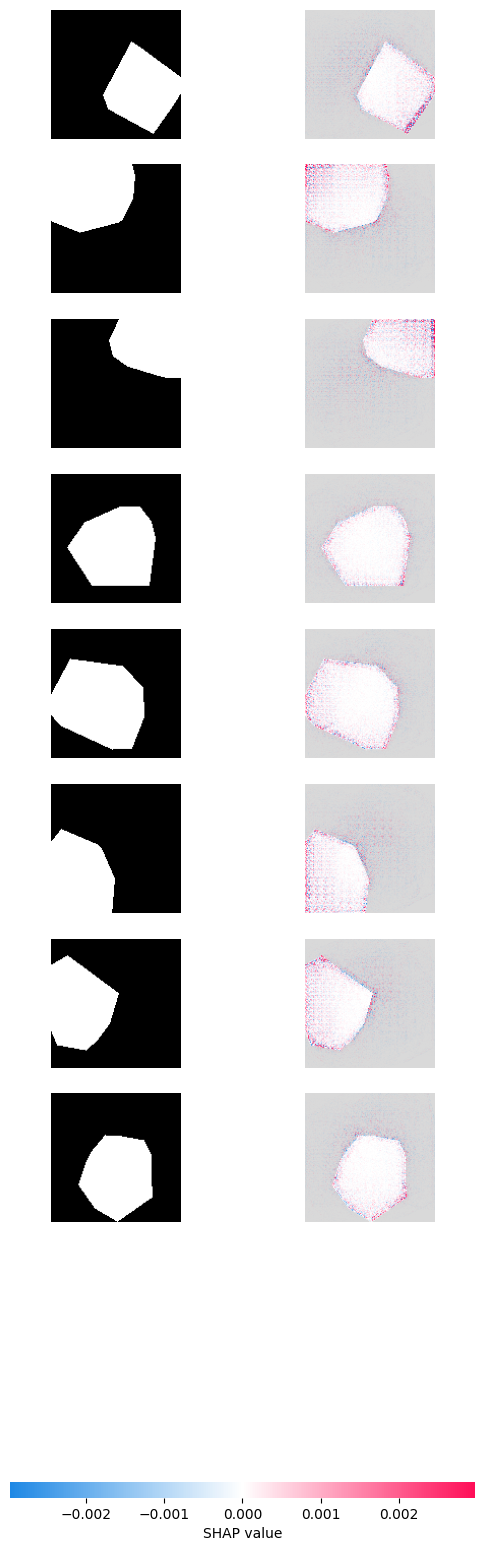

In [10]:
def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)


def _strip_output_axis_if_needed(sv: np.ndarray) -> np.ndarray:
    """
    SHAP GradientExplainer sometimes returns SHAP values with an extra
    output axis:
        (B, O, H, W, C) or (B, O, C, H, W) or (B, O, H, W)

    If O == 1, we strip it safely to get:
        (B, H, W, C) / (B, C, H, W) / (B, H, W)
    """
    if sv.ndim == 5:
        # (B, O, ...)
        if sv.shape[1] == 1:
            return sv[:, 0, ...]
        # multi-output case: you must choose which output index to explain
        raise ValueError(f"SHAP values have multiple outputs O={sv.shape[1]}. "
                         f"Select one output index explicitly.")
    if sv.ndim == 4:
        # could be (B, O, H, W) in some edge cases
        if sv.shape[1] == 1 and sv.shape[-1] not in (1, 3, 4):
            # heuristic: if second dim is 1 and last dim is not channel,
            # treat dim1 as output axis and strip it.
            return sv[:, 0, ...]
    return sv


def _to_channel_last_batch(a: np.ndarray) -> np.ndarray:
    """
    Normalize to (B,H,W,C).

    Accepts:
      - (B,1,H,W)  channel-first grayscale
      - (B,C,H,W)  channel-first
      - (B,H,W,1)  channel-last grayscale
      - (B,H,W,C)  channel-last
      - (B,H,W)    implicit grayscale
    """
    a = np.asarray(a)

    # (B,H,W) -> (B,H,W,1)
    if a.ndim == 3:
        return a[..., None]

    if a.ndim != 4:
        raise ValueError(f"Expected 3D or 4D array after output-axis stripping, got shape {a.shape}")

    # already channel-last
    if a.shape[-1] in (1, 3, 4):
        return a

    # channel-first
    if a.shape[1] in (1, 3, 4):
        return np.transpose(a, (0, 2, 3, 1))

    raise ValueError(f"Cannot infer channel dimension for shape {a.shape}")


def _ensure_rgb(a_bhwc: np.ndarray) -> np.ndarray:
    """
    If grayscale (C=1), replicate to RGB (C=3) so matplotlib/shap.image_plot is stable.
    """
    if a_bhwc.shape[-1] == 1:
        return np.repeat(a_bhwc, 3, axis=-1)
    return a_bhwc


# -----------------------------
# Model wrapper for SHAP
# -----------------------------

class _ShapModel(nn.Module):
    """
    Ensure output is strictly (B,1) because GradientExplainer assumes 2D outputs.
    """
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.base(x)
        if y.ndim == 1:
            y = y.unsqueeze(1)
        if y.ndim != 2:
            raise RuntimeError(f"Model output must be 2D (B,1). Got shape {tuple(y.shape)}")
        if y.shape[1] != 1:
            y = y[:, :1]
        return y


# -----------------------------
# Main SHAP function
# -----------------------------

def explain_with_shap(
    dataset_root: Path,
    checkpoint: Path,
    img_size: int,
    num_explain: int = 8,
    seed: int = 42,
    device: str | None = None,
    background_size: int = 64,
    use_cpu_for_shap: bool = True,
) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)

    runtime_device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    shap_device = "cpu" if use_cpu_for_shap else runtime_device
    print(f"[explain] runtime_device={runtime_device}")
    print(f"[explain] shap_device={shap_device} (use_cpu_for_shap={use_cpu_for_shap})")

    ds_train = PolygonDiameterDataset(dataset_root, "train", img_size=img_size, seed=seed)
    ds_val   = PolygonDiameterDataset(dataset_root, "val",   img_size=img_size, seed=seed)

    # Load model
    ckpt = torch.load(checkpoint, map_location=runtime_device)
    base_model = SimpleCNNRegressor(in_ch=1).to(runtime_device)
    base_model.load_state_dict(ckpt["model_state"])
    base_model.eval()

    model = _ShapModel(base_model).to(shap_device)
    model.eval()

    # Background
    bg_n = min(int(background_size), len(ds_train))
    bg_idx = np.random.choice(len(ds_train), size=bg_n, replace=False)
    background = torch.stack([ds_train[i][0] for i in bg_idx], dim=0).to(shap_device)  # (B,1,H,W)

    # Explain batch
    ex_n = min(int(num_explain), len(ds_val))
    ex_idx = np.random.choice(len(ds_val), size=ex_n, replace=False)
    explain_x = torch.stack([ds_val[i][0] for i in ex_idx], dim=0).to(shap_device)     # (B,1,H,W)
    explain_y = torch.stack([ds_val[i][1] for i in ex_idx], dim=0).to(shap_device)     # (B,1)

    # Sanity check: output must be (B,1)
    with torch.no_grad():
        out = model(explain_x[:2])
    print(f"[explain] model output shape check: {tuple(out.shape)}")
    if not (out.ndim == 2 and out.shape[1] == 1):
        raise RuntimeError("Model output must be (B,1) for this SHAP pipeline.")

    # Explainer
    explainer = shap.GradientExplainer(model, background)

    # Compute SHAP values
    shap_values = explainer.shap_values(explain_x)

    # Print preds
    with torch.no_grad():
        pred = model(explain_x).detach().cpu().numpy().reshape(-1)
        true = explain_y.detach().cpu().numpy().reshape(-1)

    print("[explain] normalized targets (true vs pred):")
    for i in range(ex_n):
        print(f"  {i:02d}: true={true[i]:.4f}, pred={pred[i]:.4f}")

    # ---- Normalize SHAP return type robustly ----
    sv = shap_values
    if isinstance(sv, list):
        # many versions return list per output; regression usually list length 1
        sv = sv[0]

    sv = _to_numpy(sv)
    sv = _strip_output_axis_if_needed(sv)   # <-- 핵심: (B,O,...)에서 O 제거
    sv = _to_channel_last_batch(sv)         # (B,H,W,C)
    sv = _ensure_rgb(sv)                    # (B,H,W,3)

    # ---- Normalize images ----
    img = _to_numpy(explain_x)              # (B,1,H,W)
    img = _to_channel_last_batch(img)       # (B,H,W,1)
    img = _ensure_rgb(img)                  # (B,H,W,3)

    # Plot (always stable shapes)
    shap.image_plot([sv], img, show=True)


ckpt = Path("/content/drive/MyDrive/0-학자연/dataset/simple_cnn_best.pt")
if not ckpt.exists():
    raise FileNotFoundError(f"Checkpoint not found: {ckpt}")
explain_with_shap(
    dataset_root=Path.cwd() / "dataset",
    checkpoint=ckpt,
    img_size=IMG_SIZE,
    num_explain=8,
)

[compare] file: 000123.png
  true_diameter      = 1.493135
  pred_diameter      = 1.493258
  abs_error          = 0.000124
  rel_error          = 0.008%
  true_normalized    = 0.527903
  pred_normalized    = 0.527947


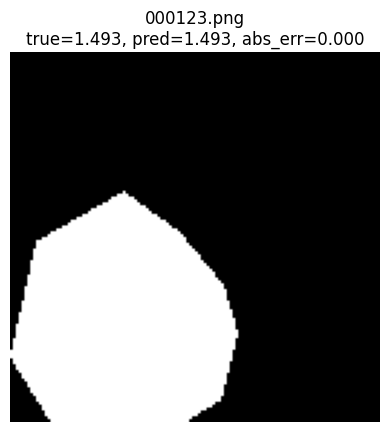

[compare] split=val, index=0
  true_diameter      = 1.499270
  pred_diameter      = 1.457214
  abs_error          = 0.042056
  rel_error          = 2.805%
  true_normalized    = 0.530072
  pred_normalized    = 0.515203


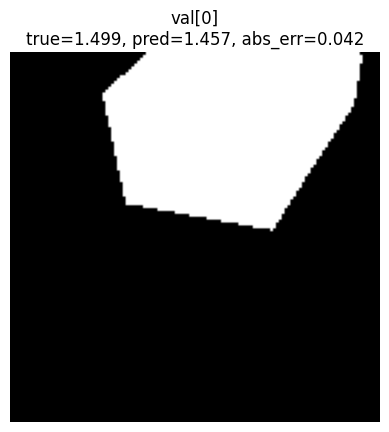

{'split': 'val',
 'index': 0,
 'true_diameter': 1.4992701173529304,
 'pred_diameter': 1.4572139688600318,
 'true_normalized': 0.530072033405304,
 'pred_normalized': 0.5152029395103455,
 'abs_error': 0.042056148492898515,
 'rel_error': 0.02805108166042266}

In [12]:
from __future__ import annotations
from pathlib import Path
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------------------------------------
# Helpers: labels.csv에서 filename -> true_diameter 조회
# ------------------------------------------------------------

def load_labels_map(dataset_root: Path) -> dict[str, float]:
    labels_path = Path(dataset_root) / "labels.csv"
    m = {}
    with open(labels_path, "r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            m[row["filename"]] = float(row["diameter"])
    return m


def diameter_scale() -> float:
    # Dataset 클래스에서 사용한 스케일과 동일해야 합니다.
    # [-1,1]^2에서 최대 거리 = 2*sqrt(2)
    return 2.0 * (2.0 ** 0.5)


# ------------------------------------------------------------
# 1) filename으로 특정 이미지의 true/pred 비교
# ------------------------------------------------------------

@torch.no_grad()
def compare_true_pred_by_filename(
    dataset_root: Path,
    checkpoint: Path,
    filename: str,
    img_size: int,
    device: str | None = None,
    show_image: bool = True,
) -> dict:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Load label
    labels = load_labels_map(dataset_root)
    if filename not in labels:
        raise FileNotFoundError(f"filename '{filename}' not found in labels.csv")

    true_diam = labels[filename]

    # Load image -> tensor (1,1,H,W)
    img_path = Path(dataset_root) / "images" / filename
    if not img_path.exists():
        raise FileNotFoundError(f"image not found: {img_path}")

    img = Image.open(img_path).convert("L")
    if img.size != (img_size, img_size):
        img = img.resize((img_size, img_size), resample=Image.Resampling.BILINEAR)

    x = np.array(img, dtype=np.float32) / 255.0
    x = torch.from_numpy(x[None, None, :, :]).to(device)  # (1,1,H,W)

    # Load model
    ckpt = torch.load(checkpoint, map_location=device)
    model = SimpleCNNRegressor(in_ch=1).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # Predict (normalized and original)
    pred_norm = model(x).item()  # since output (1,1)
    scale = diameter_scale()
    pred_diam = pred_norm * scale

    # Also provide normalized true (consistent with training)
    true_norm = true_diam / scale

    result = {
        "filename": filename,
        "true_diameter": true_diam,
        "pred_diameter": pred_diam,
        "true_normalized": true_norm,
        "pred_normalized": pred_norm,
        "abs_error": abs(pred_diam - true_diam),
        "rel_error": abs(pred_diam - true_diam) / max(true_diam, 1e-8),
    }

    print(f"[compare] file: {filename}")
    print(f"  true_diameter      = {result['true_diameter']:.6f}")
    print(f"  pred_diameter      = {result['pred_diameter']:.6f}")
    print(f"  abs_error          = {result['abs_error']:.6f}")
    print(f"  rel_error          = {result['rel_error']*100:.3f}%")
    print(f"  true_normalized    = {result['true_normalized']:.6f}")
    print(f"  pred_normalized    = {result['pred_normalized']:.6f}")

    if show_image:
        plt.figure()
        plt.imshow(np.array(img), cmap="gray")
        plt.title(
            f"{filename}\ntrue={true_diam:.3f}, pred={pred_diam:.3f}, abs_err={result['abs_error']:.3f}"
        )
        plt.axis("off")
        plt.show()

    return result


# ------------------------------------------------------------
# 2) Dataset 인덱스로 특정 샘플의 true/pred 비교 (val 또는 train)
# ------------------------------------------------------------

@torch.no_grad()
def compare_true_pred_by_index(
    dataset_root: Path,
    checkpoint: Path,
    index: int,
    img_size: int,
    split: str = "val",     # "train" or "val"
    seed: int = 42,
    device: str | None = None,
    show_image: bool = True,
) -> dict:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    ds = PolygonDiameterDataset(dataset_root, split, img_size=img_size, seed=seed)
    if index < 0 or index >= len(ds):
        raise IndexError(f"index out of range: {index} (len={len(ds)})")

    x, y = ds[index]  # x: (1,H,W), y: (1,) normalized target
    x_b = x.unsqueeze(0).to(device)  # (1,1,H,W)
    true_norm = y.item()

    ckpt = torch.load(checkpoint, map_location=device)
    model = SimpleCNNRegressor(in_ch=1).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    pred_norm = model(x_b).item()

    scale = diameter_scale()
    true_diam = true_norm * scale
    pred_diam = pred_norm * scale

    result = {
        "split": split,
        "index": index,
        "true_diameter": true_diam,
        "pred_diameter": pred_diam,
        "true_normalized": true_norm,
        "pred_normalized": pred_norm,
        "abs_error": abs(pred_diam - true_diam),
        "rel_error": abs(pred_diam - true_diam) / max(true_diam, 1e-8),
    }

    print(f"[compare] split={split}, index={index}")
    print(f"  true_diameter      = {result['true_diameter']:.6f}")
    print(f"  pred_diameter      = {result['pred_diameter']:.6f}")
    print(f"  abs_error          = {result['abs_error']:.6f}")
    print(f"  rel_error          = {result['rel_error']*100:.3f}%")
    print(f"  true_normalized    = {result['true_normalized']:.6f}")
    print(f"  pred_normalized    = {result['pred_normalized']:.6f}")

    if show_image:
        img_np = x.squeeze(0).numpy()  # (H,W)
        plt.figure()
        plt.imshow(img_np, cmap="gray")
        plt.title(
            f"{split}[{index}]\ntrue={true_diam:.3f}, pred={pred_diam:.3f}, abs_err={result['abs_error']:.3f}"
        )
        plt.axis("off")
        plt.show()

    return result


dataset_root = Path.cwd() / "dataset"
ckpt = Path("/content/drive/MyDrive/0-학자연/dataset/simple_cnn_best.pt")

compare_true_pred_by_filename(dataset_root, ckpt, "000123.png", img_size=IMG_SIZE, show_image=True)

# 2) val split에서 index로 비교
compare_true_pred_by_index(dataset_root, ckpt, index=0, img_size=IMG_SIZE, split="val", show_image=True)